# Lesson 12 Ridge Regression 

**Regularization** is about techniques used to calibrate ML models to minimize the adjusted loss function and prevent overfitting or underfitting.   

Is a method for estimating the coefficients of multiple-regression models in scenarios where independent variables are highly correlated.

We will be using the life_expectancy data set from lesson 11.  

We penalize weights that are too large in magnitude, compared to OLS using the $L2$ norm:

\begin{align}
    min_w ||y - Xw||_2^2 + \lambda ||w||_2^2
\end{align}

Where the second term penalizes weights that are too large in magnitude.  $\lambda$ is a tuning parameter that determines how much we penalize these weights.  

We can implement an existing version of Ridge regression using the scikit-learn library. It does all of the steps we have shown in the portions here, but in a pre-existing way so that it will do cross validation for us as well. The point of showing it here is so that we see what is supposed to happen under the hood of the scikit-learn implementation.

# Imports

In [1]:
# Reference parent directory
%cd ..

/Users/jaimemerizalde/Desktop/Library/Machine Learning Udemy Course


In [2]:
from Library import data
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 

from yellowbrick.regressor import AlphaSelection


# Get Data

In [4]:
df = data.get_data("Datasets/LifeExpectancy.csv", index_col=[0])

# Preprocessing

In [5]:
# Remove Missing values and Categorical Variables

# Recast Categorical Variables
## identify cat vars
categorical_columns = list(df.dtypes[df.dtypes=="O"].index.values)
categorical_columns

## recast non-numerical/object columns to CAT VARS:
for column in categorical_columns:
    df[column] = df[column].astype("category")
df.dtypes

# Train Test Split
X = df.loc[:, df.columns != "life_expectancy"]
y = df["life_expectancy"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Enforce Removing nonNumerical and missing values.
X_train, y_train = data.remove_missing_and_nonNumerical_values(X_train, y_train)
X_test, y_test = data.remove_missing_and_nonNumerical_values(X_test, y_test)

Original Size X: (1968, 21) y: (1968,)
Removed ['country' 'status']
New Size X: (1123, 19) y: (1123,)
Original Size X: (970, 21) y: (970,)
Removed ['country' 'status']
New Size X: (526, 19) y: (526,)


# Ridge Regression

## Cross Validation and Metrics

We will explore multiple lambdas for ridge regression and determine which weights may be the best.

In [ ]:
from sklearn.linear_model import Ridge

ridge_cross_validation_metrics = pd.DataFrame(columns=["mean MSE", "mean norm MSE", "mean R2"])
lambdas = [1e-4, 1e-3, 1e-2, 0.1, 0.5, 1, 10, 50, 100] 

# Now calculate the cross validation metrics for each lambda. 

for lambda_ in lambdas:
    k_fold = KFold(n_splits=5)

    cv_mse = []
    cv_norm_mse = []
    cv_r2 = []

    # Calculate the metric for each partition and take the mean.
    i = 1 
    for train_index, test_index in k_fold.split(X_train):
        # option to print the test fold data
        # print(f"Lambda: {lambda_}: Split: {i}\n\tTest folds: {i}\n\tTrain folds: {[j for j in range(1, kfold.n_splits + 1) if j != i]}")

        x_train_fold = X_train.values[train_index]
        y_train_fold = y_train.values[train_index]
        x_test_fold = X_train.values[test_index]
        y_test_fold = y_train.values[test_index]

        # Perform the model regression w kfold data.
        ridge_reg = Ridge(alpha=lambda_).fit(x_train_fold, y_train_fold)
        y_hat_fold = ridge_reg.predict(x_test_fold)

        # Calculate the metrics of performance.
        mse_fold = mean_squared_error(y_test_fold, y_hat_fold)
        r2_fold = r2_score(y_test_fold, y_hat_fold)
        norm_mse_fold = 1 - r2_fold
        print(f"MSE Fold: {mse_fold: 3.3f}, Norm MSE Fold: {norm_mse_fold: 3.3f}, R2 Fold: {r2_fold: 3.3f}")

        # Capture the values of the cross validation at the specific fold.
        # These are later used to calculate a mean.
        cv_mse.append(mse_fold)
        cv_norm_mse.append(norm_mse_fold)
        cv_r2.append(r2_fold)
    
    # Calculate the mean of each cross validation metric at this lambda. Store in the row of the validation metrics df.
    ridge_cross_validation_metrics.loc[f"Lambda {lambda_}", :] = [np.mean(cv_mse), np.mean(cv_norm_mse), np.mean(cv_r2)]

ridge_cross_validation_metrics.sort_values(by="mean R2", ascending=False)


MSE Fold:  15.126, Norm MSE Fold:  0.156, R2 Fold:  0.844
MSE Fold:  12.915, Norm MSE Fold:  0.186, R2 Fold:  0.814
MSE Fold:  15.121, Norm MSE Fold:  0.205, R2 Fold:  0.795
MSE Fold:  13.265, Norm MSE Fold:  0.170, R2 Fold:  0.830
MSE Fold:  13.932, Norm MSE Fold:  0.189, R2 Fold:  0.811
MSE Fold:  15.126, Norm MSE Fold:  0.156, R2 Fold:  0.844
MSE Fold:  12.915, Norm MSE Fold:  0.186, R2 Fold:  0.814
MSE Fold:  15.121, Norm MSE Fold:  0.205, R2 Fold:  0.795
MSE Fold:  13.265, Norm MSE Fold:  0.170, R2 Fold:  0.830
MSE Fold:  13.932, Norm MSE Fold:  0.189, R2 Fold:  0.811
MSE Fold:  15.125, Norm MSE Fold:  0.156, R2 Fold:  0.844
MSE Fold:  12.916, Norm MSE Fold:  0.186, R2 Fold:  0.814
MSE Fold:  15.121, Norm MSE Fold:  0.205, R2 Fold:  0.795
MSE Fold:  13.265, Norm MSE Fold:  0.170, R2 Fold:  0.830
MSE Fold:  13.931, Norm MSE Fold:  0.189, R2 Fold:  0.811
MSE Fold:  15.115, Norm MSE Fold:  0.156, R2 Fold:  0.844
MSE Fold:  12.924, Norm MSE Fold:  0.186, R2 Fold:  0.814
MSE Fold:  15.

/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.94307e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=4.7778e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.32244e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=4.9174e-18): result may 

,mean MSE,mean norm MSE,mean R2
Lambda 0.0001,14.071758,0.181251,0.818749
Lambda 0.001,14.071758,0.181251,0.818749
Lambda 0.01,14.071756,0.181252,0.818748
Lambda 0.1,14.071843,0.18126,0.81874
Lambda 0.5,14.074464,0.181321,0.818679
Lambda 1,14.081983,0.181449,0.818551
Lambda 10,14.396175,0.185775,0.814225
Lambda 50,14.990476,0.193647,0.806353
Lambda 100,15.172327,0.196051,0.803949


Notice some of the best $\lambda$'s to choose from are 0.0001 and 0.001. This is based on the R-squared value. 

A not-to-distant second is the value 0.01.  

# Ridge Regression w Scikit-learn

In [6]:
from sklearn.linear_model import RidgeCV

lambdas = [1e-4, 1e-3, 1e-2, 0.1, 0.5, 1, 10, 50, 100]
# NOTE: fit directly on the training data because it will perform the folding for us.
ridge_cv = RidgeCV(alphas=lambdas, cv=5).fit(X_train, y_train) 

print(f"Best Lambda: {ridge_cv.alpha_} with R-squared: {ridge_cv.best_score_}")

Best Lambda: 0.0001 with R-squared: 0.8187486890969113


/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.94307e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=4.7778e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.32244e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=4.9174e-18): result may 

We can confirm this is the same solution we came up with in the expanded under-the-hood implementation. 

# Saving Weights

In [21]:
filename = %pwd 
filename += "/Lesson 12 - Ridge Regression/ridge_cv_weights.csv"
data.save_weights(ridge_cv.coef_, filename)


# Visualizing with AlphaSelection

AlphaSelection(ax=<Axes: >,
               estimator=RidgeCV(alphas=[0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10,
                                         50, 100],
                                 store_cv_values=True))

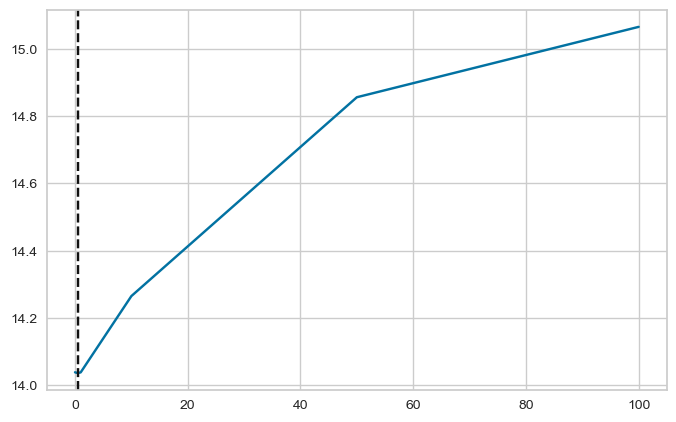

In [19]:
from yellowbrick.regressor import AlphaSelection

plt.figure(figsize=(8, 8 / 1.618));

visualization = AlphaSelection(RidgeCV(alphas=lambdas))
visualization.fit(X_train, y_train) 


# Discussion

We recommend using the smaller scikit-learning implementation, however, we need to understand what is going on inside. 

One more important point. It looks like we have the same "fit" ie MSE for both the linear regression model and this ridge regression method. Both via cross validation. We will discuss more on this later, because there is an important reason. 